## Full Model

Now that we can generate predictions, let's train a few models on a few folds of the dataset.

In [1]:
import os
import sys
import PIL
import shutil
import pandas as pd
import numpy as np
from functools import partial
from sklearn.model_selection import KFold

import torch

import fastai
from fastai.core import is_tuple
from fastai.train import ShowGraph
from fastai.vision import Path, open_image, ImageBBox, ObjectItemList, get_transforms, bb_pad_collate, conv_layer
from fastai.vision import Learner, create_body, models, conv2d, ifnone, DatasetType, range_of, progress_bar, cnn_learner, Image
from fastai.vision.data import pil2tensor

from RetinaNet.object_detection_helper import process_output, nms, rescale_boxes, GeneralEnsemble
from RetinaNet.object_detection_helper import create_anchors, get_annotations_from_path
from RetinaNet.inference import get_bounding_box_predictions_for_dataset
from RetinaNet.RetinaNetFocalLoss import FocalLoss
from RetinaNet.RetinaNet import RetinaNet
from RetinaNet.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric

# Make required folders if they're not already present
directories = ['./kfolds', './model_predictions', './model_source']
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

In [2]:
NFOLDS = 10

batch_size = 64
image_size = 256

DATA = Path('data/')
IMAGES = DATA/'train_labelled_images'
ANNOTATIONS = DATA/'train_labelled_annotations'
TEST = DATA/'sorghum_test_public'

images, lbl_bbox = get_annotations_from_path(ANNOTATIONS, IMAGES)
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[IMAGES/o.name]

script_name = os.path.basename('03_FullModel').split('.')[0]
MODEL_NAME = "{0}__folds{1}".format(script_name, NFOLDS)

print("Model: {}".format(MODEL_NAME))

kf = KFold(n_splits=NFOLDS)

#Out of fold predictions, one row for each training image 
# with a variable length list for predicted bounding boxes
oof_preds = np.empty((len(images),), dtype=object)
for i,v in enumerate(oof_preds): 
    oof_preds[i] = []
    
tfms = get_transforms(do_flip=True, max_rotate=0, max_lighting=0.1, max_zoom=0, max_warp=0.)

def get_data(bs, size, val_index):
    src = ObjectItemList.from_folder(IMAGES)
    src = src.split_by_idx(val_index)
    src = src.label_from_func(get_y_func)
    src = src.transform(get_transforms(), size=size, tfm_y=True)
    return src.databunch(path=IMAGES, bs=16, collate_fn=bb_pad_collate)


Model: 03_FullModel__folds10


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.920563,2.266038,0.016196,0.560610,1.705429,0.016196,00:11


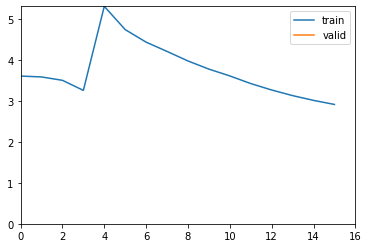

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.644244,2.485212,0,0.574243,1.910969,0,00:08


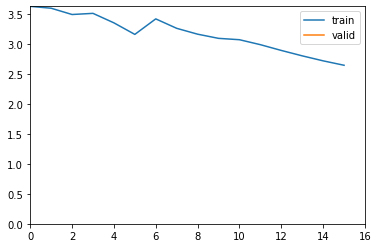

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,3.639908,2.991371,0,0.577119,2.414252,0,00:07


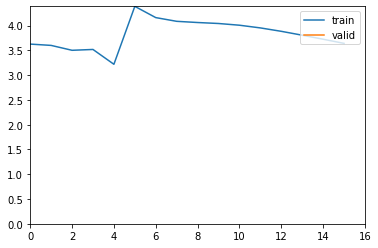

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.997816,2.916027,0,0.552019,2.364009,0,00:07


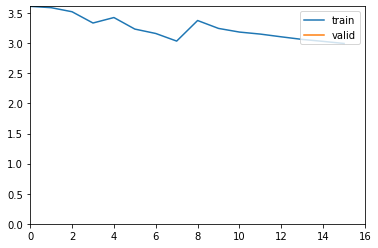

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.351853,2.240550,0.002579,0.534257,1.706293,0.002579,00:07


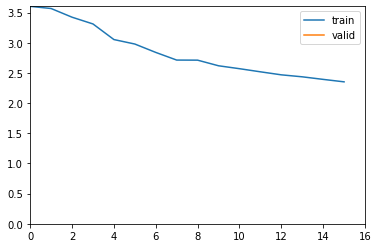

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.417028,2.443355,0,0.564422,1.878932,0,00:07


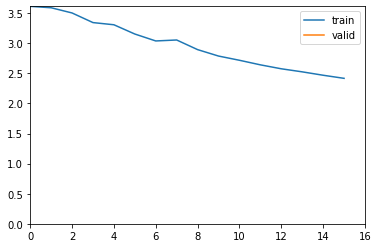

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,3.238881,2.629035,0,0.567243,2.061792,0,00:07


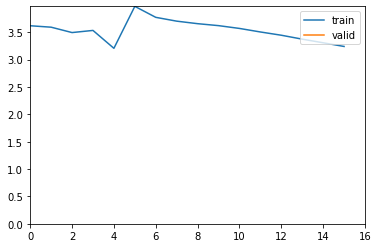

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,4.752921,2.743227,0,0.588212,2.155015,0,00:07


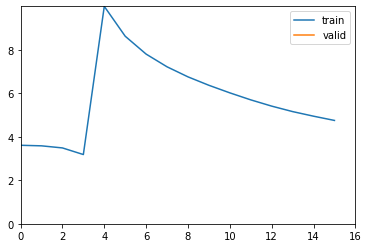

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.481767,2.220834,0.014245,0.582167,1.638667,0.014245,00:07


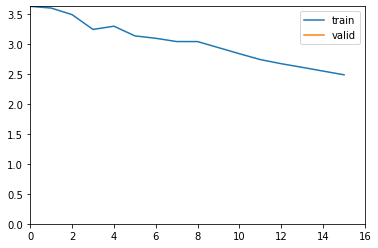

30


epoch,train_loss,valid_loss,pascal_voc_metric,BBloss,focal_loss,AP-0,time
0,2.389729,2.592062,0,0.574952,2.017110,0,00:07


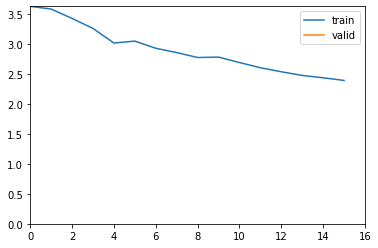

30


NameError: name 'calculate_overall_lwlrap_sklearn' is not defined

In [3]:
for i, (train_index, val_index) in enumerate(kf.split(images)):

    data = get_data(batch_size, image_size, val_index)

    anchors = create_anchors(sizes=[(32,32),(16,16),(8,8),(4,4),(2,2)], ratios=[0.5, 1, 2], scales=[0.35, 0.5, 1])
    n_classes = data.train_ds.c

    crit = FocalLoss(anchors)
    encoder = create_body(models.resnet101, True, -2)
    model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=9, chs=32, final_bias=-4., n_conv=2)

    voc = PascalVOCMetric(anchors, image_size, [i for i in data.train_ds.y.classes[1:]])
    learn = Learner(data, model, loss_func=crit, callback_fns=[ShowGraph, BBMetrics], metrics=[voc])
    learn.split([model.encoder[6], model.c5top5])
    
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, 1e-3)
    
    #learn.unfreeze()
    #learn.fit_one_cycle(100, slice(1e-5, 1e-4))

    all_preds = list(get_bounding_box_predictions_for_dataset(learn, anchors))
    
    print(len(all_preds))

    oof_preds[val_index] = all_preds

    #Save learner
    #TODO: Export with name
    learn.export(file=MODEL_NAME + '_' + str(i))

    #Get test predictions
    

score = calculate_overall_lwlrap_sklearn(oof_preds, transformed_y).numpy()[0]

print("Saving out-of-fold predictions...")
all_oof_preds = pd.DataFrame(np.hstack((filenames, oof_preds)), columns = test.columns)
all_oof_preds.to_csv('./kfolds/{}__{}.csv'.format(MODEL_NAME, str(score)), index=False)

print("Saving code...")
shutil.copyfile(os.path.basename(__file__), './model_source/{}__{}.py'.format(MODEL_NAME, str(score)))

print("Saving submission file...")
# Adjust test predictions for number of folds and save
test_preds /= NFOLDS
test[learn.data.classes] = test_preds
test.to_csv('./model_predictions/submission_{}__{}.csv'.format(MODEL_NAME, str(score)), index=False)